# Theano, Lasagne
и с чем их едят

Ещё не установили их - пока __```pip install theano```__ или __```conda install Theano```__, а после - установите

# разминка
* напиши на numpy функцию, которая считает сумму квадратов чисел от 0 до N, где N - аргумент
* массив чисел от 0 до N - numpy.arange(N)

In [7]:
import numpy as np
def sum_squares(N):
    return np.sum(np.square(np.arange(N)))

In [5]:
%%time
sum_squares(10**8)

CPU times: user 520 ms, sys: 528 ms, total: 1.05 s
Wall time: 1.1 s


662921401752298880

# theano teaser

Как сделать то же самое

In [6]:
import theano
import theano.tensor as T

In [7]:
#будущий параметр функции
N = T.scalar("a dimension", dtype='int32')

#рецепт получения суммы квадратов
result = (T.arange(N)**2).sum()

#компиляция функции "сумма квадратов" чисел от 0 до N
sum_function = theano.function(inputs = [N], outputs=result)

In [8]:
%%time
sum_function(10**8)

CPU times: user 303 ms, sys: 257 ms, total: 560 ms
Wall time: 558 ms


array(662921401752298880)

# Как оно работает?
__Если вы читаете это в аудитории - скорее всего прямо сейчас преподы объясняют то же самое__
* Нужно написать "рецепт" получения выходов по входам
* То же самое на заумном: нужно описать символический граф вычислений


* 2 вида зверей - "входы" и "преобразования"
* Оба могут быть числами, массивами, матрицами, тензорами и т.п.


* Вход - это то аргумент функции. То место, на которое подставится аргумент вызове.
 * N - вход в примере выше


* Преобразования - рецепты вычисления чего-то на основе входов и констант
 * (T.arange(N)^2).sum() - 3 последовательных преобразования N
 * Работают почти 1 в 1 как векторные операции в numpy
 * почти всё, что есть в numpy есть в theano tensor и называется так же
   * np.mean -> T.mean
   * np.arange -> T.arange
   * np.cumsum -> T.cumsum
   * и так далее...
   * Совсем редко - бывает, что меняется название или синтаксис - нужно спросить у семинаристов или гугла
 
 
Ничего не понятно? Сейчас исправим.

In [9]:
#входы

example_input_integer = T.scalar("вход - одно число(пример)", dtype='float32')

example_input_tensor = T.tensor4("вход - четырёхмерный тензор(пример)")
#не бойся, тензор нам не пригодится

input_vector = T.vector("вход - вектор целых чисел", dtype='int32')

In [10]:
#преобразования

#поэлементное умножение
double_the_vector = input_vector*2

#поэлементный косинус
elementwise_cosine = T.cos(input_vector)

#разность квадрата каждого элемента и самого элемента
vector_squares = input_vector**2 - input_vector

In [11]:
double_the_vector

Elemwise{mul,no_inplace}.0

In [12]:
#теперь сам:
#создай 2 вектора из чисел float32
my_vector = T.vector(dtype='float32')
my_vector2 = T.vector(dtype='float32')

In [13]:
#напиши преобразование, которое считает
#(вектор 1)*(вектор 2) / (sin(вектор 1) +1)
my_transformation = my_vector*my_vector2/(T.sin(my_vector) + 1)

In [14]:
print my_transformation
#то, что получилась не чиселка - это нормально

Elemwise{true_div,no_inplace}.0


# Компиляция
* До этого момента, мы использовали "символические" переменные
 * писали рецепт вычислений, но ничего не вычисляли
* чтобы рецепт можно было использовать, его нужно скомпилировать

In [15]:
inputs = [my_vector, my_vector2]
outputs = [my_transformation]

# можно скомпилировать написанные нами преобразования как функцию
my_function = theano.function(
    inputs, 
    outputs,
    allow_input_downcast=True #автоматически прводить типы (необязательно)
)

In [16]:
#можно вызвать вот-так:
print "using python lists:"
print my_function([1,2,3], [4,5,6])
print

#а можно так. 
#К слову, ту тип float приводится к типу второго вектора
print "using numpy arrays:"
print my_function(np.arange(10), np.linspace(5, 6, 10, dtype='float'))

using python lists:
[array([  2.1721766 ,   5.23752832,  15.77397728], dtype=float32)]

using numpy arrays:
[array([   0.        ,    2.77555895,    5.47030783,   14.02131271,
         89.5477066 ,  676.25805664,   47.183918  ,   24.4084301 ,
         23.68156242,   38.24041748], dtype=float32)]


# хинт для отладки
* Если ваша функция большая, компиляция может отнять какое-то время.
* Чтобы не ждать, можно посчитать выражение без компиляции
* Вы экономите время 1 раз на компиляции, но сам код выполняется медленнее


In [17]:
#словарик значений для входов
my_function_inputs = {
    my_vector:[1,2,3],
    my_vector2:[4,5,6]
}

#вычислить без компиляции
#если мы ничего не перепутали, 
#должно получиться точно то же, что и раньше
print my_transformation.eval(my_function_inputs)


#можно вычислять преобразования на ходу
print "сумма 2 векторов", (my_vector + my_vector2).eval(my_function_inputs)

#!ВАЖНО! если преобразование зависит только от части переменных,
#остальные давать не надо
print "форма первого вектора", my_vector.shape.eval({
        my_vector:[1,2,3]
    })

[  2.1721766    5.23752832  15.77397728]
сумма 2 векторов [ 5.  7.  9.]
форма первого вектора [3]


* Для отладки желательно уменьшить масштаб задачи. Если вы планировали послать на вход вектор из 10^9 примеров, пошлите 10~100.
* Если #ОЧЕНЬ нужно послать большой вектор, быстрее скомпилировать функцию обычным способом

# Теперь сам
__[2 балла]__

In [18]:
# Задание 1 - напиши и скомпилируй theano-функцию, которая считает среднеквадратичную ошибку двух векторов-входов
# Вернуть нужно одно число - собственно, ошибку. Обновлять ничего не нужно

vector_1 = T.vector(dtype='float32')
vector_2 = T.vector(dtype='float32')

mse_transformation = ((vector_1 - vector_2)**2).sum()/vector_1.shape

inputs = [vector_1, vector_2]
outputs = [mse_transformation]

compute_mse = theano.function(
    inputs,
    outputs,
    allow_input_downcast=True
)

In [19]:
#тесты
from sklearn.metrics import mean_squared_error

for n in [1, 5, 10, 10**3]:
    
    elems = [np.arange(n), np.arange(n, 0, -1), np.zeros(n),
             np.ones(n), np.random.random(n), np.random.randint(100, size=n)]
    
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(mean_squared_error(el, el_2))
            my_mse = compute_mse(el, el_2)
            if not np.allclose(true_mse, my_mse):
                print 'Wrong result:'
                print 'mse(%s,%s)'%(el, el_2)
                print "should be: %f, but your function returned %f"%(true_mse, my_mse)
                raise ValueError, "Что-то не так"

print "All tests passed"

All tests passed


# Shared variables

* Входы и преобразования - части рецепта. 
 * Они существуют только во время вызова функции.


* Shared переменные - всегда остаются в памяти
 * им можно поменять значение 
   * (но не внутри символического графа. Об этом позже)
 * их можно включить в граф вычислений
 
 
* хинт - в таких переменных удобно хранить параметры и гиперпараметры
 * например, веса нейронки или learning rate, если вы его меняете

In [20]:
#cоздадим расшаренную перменную
shared_vector_1 = theano.shared(np.ones(10, dtype='float64'))

In [21]:
#получить (численное) значение переменной
print "initial value", shared_vector_1.get_value()

initial value [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [22]:
#задать новое значение
shared_vector_1.set_value(np.arange(5))

#проверим значение
print "new value", shared_vector_1.get_value()

#Заметь, что раньше это был вектор из 10 элементов, а сейчас - из 5. 
#Если граф при этом остался выполним, это сработает.

new value [ 0.  1.  2.  3.  4.]


# Теперь сам

In [23]:
#напиши рецепт (преобразование), которое считает произведение(поэллементное) shared_vector на input_scalar
#скомпилируй это в функцию от input_scalar

input_scalar = T.scalar('coefficient', dtype='float32')
shared_vector_1.set_value(np.arange(5))

scalar_times_shared = shared_vector_1*input_scalar

inputs = [input_scalar]
outputs = [scalar_times_shared]
shared_times_n = theano.function(inputs, outputs)

In [24]:
print "shared:", shared_vector_1.get_value()

print "shared_times_n(5)",shared_times_n(5)

print "shared_times_n(-0.5)",shared_times_n(-0.5)

shared: [ 0.  1.  2.  3.  4.]
shared_times_n(5) [array([  0.,   5.,  10.,  15.,  20.])]
shared_times_n(-0.5) [array([-0. , -0.5, -1. , -1.5, -2. ])]


In [25]:
#поменяем значение shared_vector_1
shared_vector_1.set_value([-1, 0, 1])
print "shared:", shared_vector_1.get_value()

print "shared_times_n(5)", shared_times_n(5)

print "shared_times_n(-0.5)", shared_times_n(-0.5)

shared: [-1.  0.  1.]
shared_times_n(5) [array([-5.,  0.,  5.])]
shared_times_n(-0.5) [array([ 0.5, -0. , -0.5])]


# T.grad, самое вкусное
* theano умеет само считать производные. Все, которые существуют.
* Производные считаются в символическом, а не численном виде

Ограничения
* За раз можно считать производную __скалярной__ функции по одной или нескольким скалярным или векторным аргументам
* Функция должна на всех этапах своего вычисления иметь тип float32 или float64 (т.к. на множестве целых чисел производная не имеет смысл)

In [26]:
my_scalar = T.scalar(name='input', dtype='float64')

scalar_squared = T.sum(my_scalar**2)

#производная v_squared по my_vector
derivative = T.grad(scalar_squared, my_scalar)

fun = theano.function([my_scalar], scalar_squared)
grad = theano.function([my_scalar], derivative)

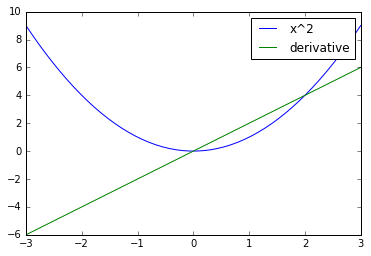

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline


x = np.linspace(-3, 3)
x_squared = map(fun, x)
x_squared_der = map(grad, x)

plt.plot(x, x_squared, label="x^2")
plt.plot(x, x_squared_der, label="derivative")
plt.legend()

# теперь сам

In [28]:
my_vector = T.vector('float64')

#посчитай производные этой функции по my_scalar и my_vector
#warning! Не пытайся понять физический смысл этой функции
weird_psychotic_function = ((my_vector + my_scalar)**(1 + T.var(my_vector)) + 1./T.arcsinh(my_scalar)).mean()/(my_scalar**2 +1) + 0.01*T.sin(2*my_scalar**1.5)*(T.sum(my_vector)* my_scalar**2)*T.exp((my_scalar - 4)**2)/(1+T.exp((my_scalar - 4)**2))*(1.-(T.exp(-(my_scalar - 4)**2))/(1+T.exp(-(my_scalar-4)**2)))**2


der_by_scalar, der_by_vector = T.grad(weird_psychotic_function, my_scalar), T.grad(weird_psychotic_function, my_vector)

compute_weird_function = theano.function([my_scalar, my_vector], weird_psychotic_function)
compute_der_by_scalar = theano.function([my_scalar, my_vector], der_by_scalar)

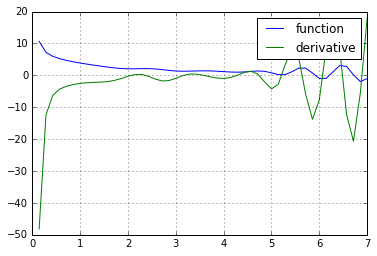

In [29]:
#график функции и твоей производной
vector_0 = [1, 2, 3]

scalar_space = np.linspace(0, 7)

y = [compute_weird_function(x, vector_0) for x in scalar_space]
plt.plot(scalar_space, y, label='function')
y_der_by_scalar = [compute_der_by_scalar(x, vector_0) for x in scalar_space]
plt.plot(scalar_space, y_der_by_scalar, label='derivative')
plt.grid();plt.legend()

# Последний штрих - Updates

* updates - это способ изменять значения shared переменных каждый раз В КОНЦЕ вызова функции

* фактически, это словарь {shared_переменная: рецепт нового значения}, который добавляется в функцию при компиляции

Например,

In [30]:
input_scalar = T.scalar('coefficient', dtype='float32')
shared_vector_1 = theano.shared(np.ones(10, dtype='float64'))

scalar_times_shared = shared_vector_1*input_scalar

In [31]:
#умножим shared вектор на число и сохраним новое значение обратно в этот shared вектор

inputs = [input_scalar]
outputs = [scalar_times_shared] #вернём вектор, умноженный на число

my_updates = {
    shared_vector_1:scalar_times_shared #и этот же результат запишем в shared_vector_1
}

compute_and_save = theano.function(inputs, outputs, updates=my_updates)

In [32]:
shared_vector_1.set_value(np.arange(5))

#изначальное значение shared_vector_1
print "initial shared value:" , shared_vector_1.get_value()

# теперь вычислим функцию (значение shared_vector_1 при этом поменяется)
print "compute_and_save(2) returns", compute_and_save(2)

#проверим, что в shared_vector_1
print "new shared value:" , shared_vector_1.get_value()

initial shared value: [ 0.  1.  2.  3.  4.]
compute_and_save(2) returns [array([ 0.,  2.,  4.,  6.,  8.])]
new shared value: [ 0.  2.  4.  6.  8.]


# Логистическая регрессия
__[4 балла]__

Задача - собрать свою собственную логистическую регрессию с блэкджеком и кроссэнтропией.

Что нам потребуется:
* Веса лучше хранить в shared-переменной
* Данные можно передавать как input
* Нужно 2 функции:
 * train_function(X,y) - возвращает ошибку и изменяет веса на 1 шаг по граиденту __(через updates)__
 * predict_fun(X) - возвращает предсказанные ответы ("y") по данным

In [33]:
from sklearn.datasets import load_digits
mnist = load_digits(2)

X, y = mnist.data, mnist.target


print "y [форма - %s]:"%(str(y.shape)), y[:10]

print "X [форма - %s]:"%(str(X.shape))
print X[:3]

y [форма - (360,)]: [0 1 0 1 0 1 0 0 1 1]
X [форма - (360, 64)]:
[[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.
    5.   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.
    0.   8.   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.
   11.   0.   1.  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.
    0.   0.   6.  13.  10.   0.   0.   0.]
 [  0.   0.   0.  12.  13.   5.   0.   0.   0.   0.   0.  11.  16.   9.
    0.   0.   0.   0.   3.  15.  16.   6.   0.   0.   0.   7.  15.  16.
   16.   2.   0.   0.   0.   0.   1.  16.  16.   3.   0.   0.   0.   0.
    1.  16.  16.   6.   0.   0.   0.   0.   1.  16.  16.   6.   0.   0.
    0.   0.   0.  11.  16.  10.   0.   0.]
 [  0.   0.   1.   9.  15.  11.   0.   0.   0.   0.  11.  16.   8.  14.
    6.   0.   0.   2.  16.  10.   0.   9.   9.   0.   0.   1.  16.   4.
    0.   8.   8.   0.   0.   4.  16.   4.   0.   8.   8.   0.   0.   1.
   16.   5.   1.  11.   3.   0.   0.   0.  12.  12.  10. 

In [34]:
# переменные и входы
shared_weights = theano.shared(np.zeros(X.shape[1], dtype='float64'))
input_X = T.matrix(dtype='float64')
input_y = T.vector(dtype='int64')

In [35]:
# predicted_y = <предсказание логрегрессии на input_X (вероятность класса)>
predicted_y = T.dot(input_X, shared_weights)

loss = T.mean(T.log(1. + T.exp(-input_y*T.dot(input_X, shared_weights))))

# grad = <градиент loss по весам модели>
grad = T.grad(loss, shared_weights)

In [36]:
updates = {
    shared_weights: shared_weights - 0.01*grad
}

# train_function = <функция, которая по X и Y возвращает ошибку и обновляет веса>
train_function = theano.function([input_X, input_y], loss, updates=updates)

# predict_function = <функция, которая по X считает предсказание для y>
prediction_function = theano.function([input_X], predicted_y)

In [37]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

loss at iter 0: 0.6931
train auc: 0.932385708798
test auc: 0.933333333333
loss at iter 1: 0.3417
train auc: 0.932385708798
test auc: 0.933333333333
loss at iter 2: 0.3417
train auc: 0.932385708798
test auc: 0.933333333333
loss at iter 3: 0.3417
train auc: 0.932495472257
test auc: 0.933333333333
loss at iter 4: 0.3417
train auc: 0.932605235717
test auc: 0.933333333333
resulting weights:


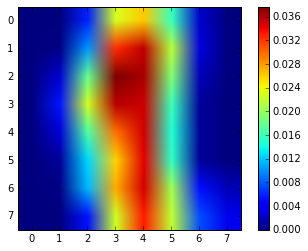

In [38]:
from sklearn.metrics import roc_auc_score

for i in range(5):
    loss_i = train_function(X_train, y_train)
    print "loss at iter %i: %.4f"%(i, loss_i)
    print "train auc:", roc_auc_score(y_train, prediction_function(X_train))
    print "test auc:", roc_auc_score(y_test, prediction_function(X_test))

    
print "resulting weights:"
plt.imshow(shared_weights.get_value().reshape(8, -1))
plt.colorbar()

# Нейроночка
__[базовая часть - 4 балла]__

Ваше финальное задание - сделать свою первую нейронку [почти] из спичек и желудей (theano).

В этот раз распознавание цифр зашло чуть дальше:
* картинки 28x28
* 10 классов
* 50k+ картинок только в обучающей выборке

Вам не нужно (но можно) создавать монстров на 152 слоя, не нужно ничего сворачивать - достаточно сделать простую нейросеть с 1 скрытым и 1 выходным слоем, которая будет работать лучше логистической регрессии.

В конце есть шаблон отчёта - его желательно вести по ходу работ (ну или хотя бы не забыть).

__[bonus score]__
Далее, если ваша сетка уже __побила результаты линейной модели__, а запал остался - можно попробовать улучшить результат ещё дальше. 
Челлендж - превзойти рубежи 95%/97.5%/98.5% точности на тесте __без использования свёрток__.

__СПОЙЛЕР!__ В конце тетрадки есть несколько советов по реализации. Если вы чувствуете в себе силы выстрелить в ногу самостоятельно - ваша воля, но наткнувшись на неразрешимые проблемы будьте добры прочитать "хвост" тетрадки, прежде, чем писать на почту.

In [19]:
from mnist import load_dataset

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

print X_train.shape, y_train.shape

(50000, 1, 28, 28) (50000,)


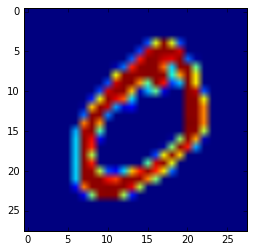

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(X_train[1, 0])

In [23]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
from learning_logistic_regression import *


sgd_optimization_mnist()

... building the model
... training the model
epoch 1, minibatch 83/83, validation error 12.458333 %
     epoch 1, minibatch 83/83, test error of best model 12.375000 %
epoch 2, minibatch 83/83, validation error 11.010417 %
     epoch 2, minibatch 83/83, test error of best model 10.958333 %
epoch 3, minibatch 83/83, validation error 10.312500 %
     epoch 3, minibatch 83/83, test error of best model 10.312500 %
epoch 4, minibatch 83/83, validation error 9.875000 %
     epoch 4, minibatch 83/83, test error of best model 9.833333 %
epoch 5, minibatch 83/83, validation error 9.562500 %
     epoch 5, minibatch 83/83, test error of best model 9.479167 %
epoch 6, minibatch 83/83, validation error 9.322917 %
     epoch 6, minibatch 83/83, test error of best model 9.291667 %
epoch 7, minibatch 83/83, validation error 9.187500 %
     epoch 7, minibatch 83/83, test error of best model 9.000000 %
epoch 8, minibatch 83/83, validation error 8.989583 %
     epoch 8, minibatch 83/83, test error of be

In [35]:
predict()

Predicted values for the first 10 examples in test set:
[7 2 1 0 4 1 4 9 6 9]


In [36]:
from hidden_layer import HiddenLayer

test_mlp()

... building the model
... training
epoch 1, minibatch 2500/2500, validation error 9.610000 %
     epoch 1, minibatch 2500/2500, test error of best model 10.080000 %
epoch 2, minibatch 2500/2500, validation error 8.590000 %
     epoch 2, minibatch 2500/2500, test error of best model 8.740000 %
epoch 3, minibatch 2500/2500, validation error 7.990000 %
     epoch 3, minibatch 2500/2500, test error of best model 8.140000 %
epoch 4, minibatch 2500/2500, validation error 7.610000 %
     epoch 4, minibatch 2500/2500, test error of best model 7.740000 %
epoch 5, minibatch 2500/2500, validation error 7.280000 %
     epoch 5, minibatch 2500/2500, test error of best model 7.550000 %
epoch 6, minibatch 2500/2500, validation error 6.970000 %
     epoch 6, minibatch 2500/2500, test error of best model 7.140000 %
epoch 7, minibatch 2500/2500, validation error 6.620000 %
     epoch 7, minibatch 2500/2500, test error of best model 6.990000 %
epoch 8, minibatch 2500/2500, validation error 6.210000 %
  

# Отчёт

Я построю свой отчет на основе рекомендуемого порядка...

**Рекомендуемый порядок:**

* Адаптировать логистическую регрессию на класификацию 1 цифры против всех (например, нулей против ненулей)

**Злостно отброшено всторону впользу второго шага**
* Обобщить логистическую регрессию до многоклассовой.
  - для этого придётся вспомнить первую лекцию или загуглить.
  
**Пришлось загуглить и удачно попасть на http://deeplearning.net/tutorial/logreg.html. Я все аккуратно прочитала и украла огромный кусок кода, от которого получила нереально удовольствие (люблю, когда существуют классы, и вообще структура в коде, поэтому раздербанила все по файлам (у каждого класса свой) и положила в шкатулку**)

  - вместо одного вектора весов у вас будет матрица (признак, класс)
  - softmax (экспонента на сумму экспонент) можно сделать самому, а можно - T.nnet.softmax (стабильная)
  
**Использовала T.nnet.softmax**

  - Лучше использовать стохастический градиентный спуск (минибатчевый)

**В моем случае batch_size=600, лучше не спрашивать почему 600, я серьезно задалась этим вопросом, прочитав 3-4 статьи, потом подумала, что не все сразу и перестала думать**

   - в котором случае выборку желательно перемешать (ну или брать случайный набор примеров на каждой итерации обучения)
   
**Это не реализованно**

* Добавить скрытый слой. Теперь ваша логистическая регрессия опирается на нейроны, а не на входы. 

**Тут я пользовалась http://deeplearning.net/tutorial/mlp.html. Опять же, восхищаюсь этим пособием, 
к примеру как лаконично тут отображается вышеописанное требование "Теперь ваша логистическая регрессия опирается на нейроны, а не на входы":**

        self.hiddenLayer = HiddenLayer(
            rng=rng,
            input=input,
            n_in=n_in,
            n_out=n_hidden,
            activation=T.tanh
        )

        self.logRegressionLayer = LogisticRegression(
            input=self.hiddenLayer.output,
            n_in=n_hidden,
            n_out=n_out

  - Принцип работы первого слоя - такой же, как у выходного, но вместо softmax у него другая нелинейность. 
  - нужно обучать оба слоя, а не только выходной :)
  
 ** :) **
 
  - важно не инициализировать веса нулями из-за эффекта симметрии. Для начала - случайный нормальный шум с маленькой "сигмой".
  
**В мое случае вышло вот так, но если честно, я не поняла, что за эффект такой, т.е. интуитивно понятно, а глубину не улавливаю. На deeplearning.net "This initialization ensures that, early in training, each neuron operates in a regime of its activation function where information can easily be propagated both upward (activations flowing from inputs to outputs) and backward (gradients flowing from outputs to inputs)." еще больше запутывает**

  W_values = numpy.asarray(
                rng.uniform(
                    low=-numpy.sqrt(6. / (n_in + n_out)),
                    high=numpy.sqrt(6. / (n_in + n_out)),
                    size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            )

  - Начать рекоммендую с 50 нейронов и сигмоиды, ибо так труднее прострелить себе ногу.
  
**Опять же, по наводке deeplearning.net взяла tanh "because it typically yields to faster training (and sometimes also to better local minima), но не поняла почему так"

  - В идеале у вас будет 2 .dot-а, 1 sigmoid и 1 softmax. 
  - __Убедитесь, что такая нейронка выучивается лучше, чем логистическая регрессия__
  
**О да, "best validation score of 1.890000 %, with test performance 2.030000 %" против "best validation score of 7.500000 %, with test performance 7.489583 %", однако я не использовала регуляризацию**
  
* Теперь время подумать над тем, как улучшить результат. Слои, нейроны, нелинейности, методы оптимизации, инициализация - всё, что хотите, разве что я бы попросил в качестве челленджа обойтись пока без свёрток.

**Дальше наверное CNN, да и на записи семинара это упоминалось. Но я на столько упоролась в то, что тут есть... В общем, мне и так хватило. Я еще какое-то время пыталась все это переписать на вариант, когда картинка хранится в формате 28x28, а не 784x1. Потратила часа 3-4,гоняясь за багами о несовпадении типов, и сдалась. Очень глупо вышло, но на первый взгляд theano-либа не богата понятными сообщениями**

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```


# SPOILERS!

Рекомендуемый порядок:

* Адаптировать логистическую регрессию на класиффикацию 1 цифры против всех (например, нулей против ненулей)
* Обобщить логистическую регрессию до многоклассовой.
  - для этого придётся вспомнить первую лекцию или загуглить.
  - вместо одного вектора весов у вас будет матрица (признак, класс)
  - softmax (экспонента на сумму экспонент) можно сделать самому, а можно - T.nnet.softmax (стабильная)
  - Лучше использовать стохастический градиентный спуск (минибатчевый)
   - в котором случае выборку желательно перемешать (ну или брать случайный набор примеров на каждой итерации обучения)
* Добавить скрытый слой. Теперь ваша логистическая регрессия опирается на нейроны, а не на входы. 
  - Принцип работы первого слоя - такой же, как у выходного, но вместо softmax у него другая нелинейность. 
  - нужно обучать оба слоя, а не только выходной :)
  - важно не инициализировать веса нулями из-за эффекта симметрии. Для начала - случайный нормальный шум с маленькой "сигмой".
  - Начать рекоммендую с 50 нейронов и сигмоиды, ибо так труднее прострелить себе ногу. 
  - В идеале у вас будет 2 .dot-а, 1 sigmoid и 1 softmax. 
  - __Убедитесь, что такая нейронка выучивается лучше, чем логистическая регрессия__
  
* Теперь время подумать над тем, как улучшить результат. Слои, нейроны, нелинейности, методы оптимизации, инициализация - всё, что хотите, разве что я бы попросил в качестве челленджа обойтись пока без свёрток.
  